### This notebook implements basic building blocks of Neural Network with simple Logistic Regression example
#### Dataset used here is taken from Kaggle Titanic set
#### Data preprocessing is inspired from Kaggle kernel  (https://www.kaggle.com/gunesevitan/titanic-survival-nn-approach)
* Block includes 
- initialize with zeros - initialize parameter W and b with zeros

iterate in a loop for gradient descent computation
- forward propagation - get Z and A; where Z= np.dot(W.T,X)+b and A is sigmoid(Z)
- compute cost - log loss
- backward propagation - get dZ, dW and db 
- update parameter - update W as W- alpha * dW and db as db- alpha * db where alpha is learning rate of gradient descent algo


In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

def grad_sigmoid(x):
    return x*(1-x)

def L1_loss(y,yhat):
    return np.sum(np.abs(y-yhat))

def L2_loss(y,yhat):
    return np.sum(np.square(y-yhat))

In [3]:
epsilon = 1e-5
def initialize_with_zeros(dim):
    W=np.zeros((dim,1))
    b=0  
#     print(W.shape,b.shape)
    assert(W.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return W,b

def forward_propagation(W,X,b):
    Z=np.dot(W.T,X)+b
    A=sigmoid(Z)
    return Z,A

def backward_propagation(A,Y,X):
    m=X.shape[1]     
    cost=compute_cost(Y,A,m)
    dZ=A-Y
    dW=(1/m)*np.dot(X,dZ.T)
    db=(1/m)*np.sum(dZ)
#     print(db)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ()) 
    grads = {"dW": dW,
             "db": db}
    return grads,cost
    
def compute_cost(Y,A,m):
    cost=(- 1 / m) * np.sum(Y * np.log(A+epsilon) + (1 - Y) * (np.log(1 - A+epsilon))) 
    return cost
    
def update_params(W,b,grads,learning_rate):
    dW = grads["dW"]
    db = grads["db"]
    W = W - learning_rate * dW  # need to broadcast
    b = b - learning_rate * db
    return W,b

def optimize(W,b,X,Y,num_iterations,learning_rate):
    costs=[]
    for i in range(num_iterations):
        Z,A=forward_propagation(W,X,b)
        grads,cost=backward_propagation(A,Y,X)
        W,b=update_params(W,b,grads,learning_rate)
        costs.append(cost)
        if i % 100 == 0:
            costs.append(cost)
    #final params dict
    params = {"W": W,
              "b": b}
    return params,grads,costs

def predict(W, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    W = W.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(W.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [4]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=5, learning_rate=0.5):
    dim=X_train.shape[0]
    W,b=initialize_with_zeros(dim)
    params,grads,costs=optimize(W,b,X_train,Y_train,num_iterations,learning_rate)
    W = params["W"]
    b = params["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(W, b, X_test)
    Y_prediction_train = predict(W, b, X_train)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "W" : W, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
    
        


In [5]:
project='titanic'
datapath = os.path.join('D:','\Learning','General','data',project)
df_train_orig = pd.read_csv(os.path.join(datapath+'/train.csv'))
df_test_orig = pd.read_csv(os.path.join(datapath+'/test.csv'))

df_train = df_train_orig.copy(deep=True)
df_train.name = 'Training set'
df_test = df_test_orig.copy(deep=True)
df_test.name = 'Test set'
for df in [df_train, df_test]:    
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
df_train.drop(['PassengerId','Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

print(df_train.columns)
print(df_test.columns)
for df in [df_train, df_test]:    
    df['Family_Members'] = df['SibSp'] + df['Parch'] + 1
    
    df['Is_Alone'] = 1
    df['Is_Alone'].loc[df['Family_Members'] > 1] = 0
    
    df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
train_title_names = (df_train['Title'].value_counts() < 10)
df_train['Title'] = df_train['Title'].apply(lambda x: 'Other' if train_title_names.loc[x] == True else x)
test_title_names = (df_test['Title'].value_counts() < 10)
df_test['Title'] = df_test['Title'].apply(lambda x: 'Other' if test_title_names.loc[x] == True else x)
le = LabelEncoder()
for df in [df_train, df_test]:
    df['Pclass'] = le.fit_transform(df['Pclass'])
    df['Sex'] = le.fit_transform(df['Sex'])
    df['Embarked'] = le.fit_transform(df['Embarked'])
    df['Title'] = le.fit_transform(df['Title'])
df_train_dummy = pd.concat([df_train, pd.get_dummies(df_train['Pclass'])], axis=1)
df_train_dummy = pd.concat([df_train_dummy, pd.get_dummies(df_train['Sex'])], axis=1)
df_train_dummy = pd.concat([df_train_dummy, pd.get_dummies(df_train['Embarked'])], axis=1)
df_train_dummy = pd.concat([df_train_dummy, pd.get_dummies(df_train['Title'])], axis=1)

df_train_dummy.drop(columns=['Pclass', 'Sex', 'Embarked', 'Title', 'Name'], inplace=True)
df_train_dummy.columns = ('Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Members', 'Is_Alone',
                         'Pclass_1', 'Pclass_2', 'Pclass_3', 'Female', 'Male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
                         'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',)
df_test_dummy = pd.concat([df_test, pd.get_dummies(df_test['Pclass'])], axis=1)
df_test_dummy = pd.concat([df_test_dummy, pd.get_dummies(df_test['Sex'])], axis=1)
df_test_dummy = pd.concat([df_test_dummy, pd.get_dummies(df_test['Embarked'])], axis=1)
df_test_dummy = pd.concat([df_test_dummy, pd.get_dummies(df_test['Title'])], axis=1)

df_test_dummy.drop(columns=['Pclass', 'Sex', 'Embarked', 'Title', 'Name'], inplace=True)
df_test_dummy.columns = ('Age', 'SibSp', 'Parch', 'Fare', 'Family_Members', 'Is_Alone',
                         'Pclass_1', 'Pclass_2', 'Pclass_3', 'Female', 'Male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
                         'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',)
for df in [df_train_dummy, df_test_dummy]:
    df['SibSp'] = (df['SibSp'] - df['SibSp'].mean()) / df['SibSp'].std()
    df['Parch'] = (df['Parch'] - df['Parch'].mean()) / df['Parch'].std()
    df['Family_Members'] = (df['Family_Members'] - df['Family_Members'].mean()) / df['Family_Members'].std()
    df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
    df['Fare'] = (df['Fare'] - df['Fare'].mean()) / df['Fare'].std()
X_train_t = df_train_dummy.drop(['Survived'], axis=1)
Y_train_t = df_train_dummy['Survived']

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')
Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')


C:\Users\Nitika Gupta\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train_t, Y_train_t, test_size=0.2)
print(X_train.shape)
print(y_train.shape)

(712, 19)
(712,)


In [13]:
train_set_x=X_train.T.values
train_set_y=y_train.values.reshape(y_train.shape[0],1).T
test_set_x=X_test.T.values
test_set_y=y_test.values.reshape(y_test.shape[0],1).T
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 500, learning_rate = 0.5)
# print(d)

train accuracy: 84.5505617977528 %
test accuracy: 78.2122905027933 %


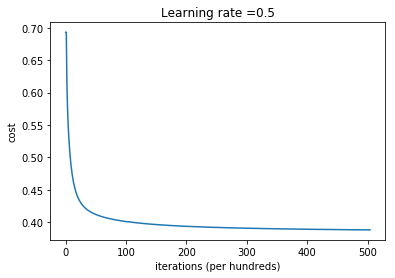

In [14]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
# print(costs)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [18]:
Y_hat = predict(d['W'], d['b'], df_test_dummy.values.T)
Y_hat.shape

(1, 418)